# Algorithms for Bandit Problems

## Setting of Bandit Problem

Now that we have $K$ bandits, each bandit (action) $a$ owns a number $q_*(a)$ from the distribution $N(0,1)$. Taking action $a$ means pulling the $a$-th bandit arm to get the reward with distribution $N(q_*(a),1)$. The rewards are always generated independently across different time steps and different bandits. The player wishes to find the best action sequence that maximizes his aggregate reward among all time steps $1,2,...,T$ ($\gamma = 1$, no discount rate in this model).

Here we only consider stationary bandit problems, i.e. $q_*(a)$ is fixed at the beginning of the game and won't change as time goes by.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import softmax

In [2]:
MOD_K = 10 # Number of bandits
MOD_T = 1000 # Time horizon

In [3]:
# Generate reward based on the action and q_*(a)
def get_reward(action,q_star_array):
    # Action can only take integer values in {0,1,...,K - 1}
    if int(action) != action or action < 0 or action > MOD_K - 1:
        error("Action value error!")
    return np.random.randn() + q_star_array[action]

## Estimation for $q_*(a)$

The estimation of $q_*(a)$ is through $Q_t(a)$ based on the information before time $t$
$$Q_t(a) = \frac{\sum_{i=1}^{t-1}R_i I_{A_i = a}}{N_t(a)},N_t(a) = \sum_{i=1}^{t-1} I_{A_i = a}$$
here $N_t(a)$ is the number of occurence of action $a$ before time $t$ and $Q_t(a)$ is a sample average of the rewards resulting from taking action $a$ before time $t$.

After deciding to take action $A_t = a$ at time $t$ and receiving the reward $r$, an update of incremental form applies
$$\forall a'\neq a,Q_{t+1}(a') = Q_{t}(a')$$
$$Q_{t+1}(a) = \frac{Q_{t}(a)N_t(a) + r}{N_t(a) + 1} = Q_t(a) + (r - Q_t(a))\frac{1}{N_t(a) + 1}$$

## Algorithms for action selection

Different algorithms provide different criterion of action selection, we test the most important algorithms in the following context.

Greedy:$$A_t = \arg\,\max_a Q_t(a)$$

$\varepsilon$-greedy: $$A_t = \arg\,\max_a Q_t(a)$$ with probability $1-\varepsilon$, with probability $\varepsilon$ take uniformly random action among all possible actions.

In [4]:
# Greedy strategy
# Inputs are current time t, T, Q_t(a), N_t(a), H_t(a)
def greedy(t,Q_est_array,N_est_array,H_est_array):
    greedy_action = np.argmax(Q_est_array)
    return greedy_action

In [5]:
# Epsilon-greedy strategy
# Epsilon is left as a global variable
def eps_greedy(t,Q_est_array,N_est_array,H_est_array):
    greedy_action = np.argmax(Q_est_array)
    if np.random.rand() < MOD_EPS:
        # Uniformly random action w.p. EPS
        action = np.random.randint(0,MOD_K)
    else:
        action = greedy_action
    return action

UCB: explore through all $K$ actions at the beginning for once, then select action based on
$$A_t = \arg\,\max_a \left(Q_t(a) + c\sqrt{\frac{\log\frac{2TK}{\delta}}{N_t(a)}}\right)$$
where $c = 1$ is taken, $\delta$ is the confidence level to be specified.

In [6]:
# UCB strategy
# MOD_delta is left as a global variable
def UCB(t,Q_est_array,N_est_array,H_est_array):
    if t < MOD_K:
        # Exploration
        action = t
    else:
        # Optimism toward uncertainty
        bound = (Q_est_array + 
            np.sqrt(np.log(2 * MOD_T * MOD_K / MOD_delta) / N_est_array))
        action = np.argmax(bound)
    return action

Gradient bandit:
maintain the preference $H_t(a)$ for each action $a$ updated through
$$H_{t+1}(a) = H_t(a) + \alpha(R_t - \overline{R_t})(I_{A_t = a} - \pi_t(a))$$
where 
$$\pi_t(a) = \text{softmax}(H_t(a))$$
provides a probability distribution on the action space so the action to take is randomized, sampled from this distribution. $\alpha>0$ is the learning rate.

In [7]:
# Gradient bandit strategy
# MOD_alpha is left as a global variable
def gradient_bandit(t,Q_est_array,N_est_array,H_est_array):
    # Apply softmax
    pi_array = softmax(H_est_array)
    
    # Sample action
    action = np.random.choice(MOD_K, p = pi_array)
    return action

## The Game Procedure and Comparison

Now we simulate the game procedure based on selected strategies. The comparison of the strategy is conducted based on Monte Carlo, i.e. repeating the game based on the selected strategy for multiple times and taking average on some of the statistics we are interested in.

Of course, we would like to compare the reward obtained at each time step and how often the strategy gives the best action at each time step. As a result, the evaluation is always generated as two plots, with the plot above as the reward obtained at each time step and the plot below as the probability the best action is taken at each time step. Both plots are constructed based on Monte Carlo.

In [8]:
MC_ITER = 2000 # 2000 times of simulation for each strategy

In [9]:
# Start the simulation of the game with a strategy specified 
# to generate actions
# The outputs are two arrays to plot later
def game(strategy):
    # strategy can only take value as function names defined above
    if strategy not in [greedy, eps_greedy, UCB, gradient_bandit]:
        error("Strategy value error!")
    
    # Average reward and probability of best action
    MC_avg_reward = np.zeros(MOD_T)
    MC_prob_best_action = np.zeros(MOD_T)
    
    for _ in range(MC_ITER):
        # Generate q_*(a)
        q_star_array = np.random.randn(MOD_K)

        # Figure out the best action
        best_action = np.argmax(q_star_array)
        
        # Maintain the estimation Q_t(a) and N_t(a)
        Q_est_array = np.zeros(MOD_K)
        N_est_array = np.zeros(MOD_K)
        
        # Maintain H_t(a) (only for gradient bandit)
        # and the mean of reward (incremental)
        H_est_array = np.zeros(MOD_K)
        mean_reward = 0
        
        # Record the reward and probability of best action at each time step
        reward_array = np.zeros(MOD_T)
        is_best_action_array = np.zeros(MOD_T)
        
        for t in range(MOD_T):
            # Figure out the action with strategy
            action = strategy(t,Q_est_array,N_est_array,H_est_array)
            
            # Take the action, get the reward
            reward = get_reward(action,q_star_array)
            
            # Record
            reward_array[t] = reward
            is_best_action_array[t] = (action == best_action)
            
            # Update the estimation
            Q_est_array[action] += (reward - Q_est_array[action]) / (N_est_array[action] + 1)
            N_est_array[action] += 1
            
            # Update H_t (only for gradient bandit)
            if strategy == gradient_bandit:
                aux_array = - softmax(H_est_array)
                aux_array[action] += 1 # I_{A_t = a} - \pi_t(a)
                mean_reward = (mean_reward * t + reward) / (t + 1)
                H_est_array += MOD_alpha * (reward - mean_reward) * aux_array
        
        # Update
        MC_avg_reward += (reward_array / MC_ITER)
        MC_prob_best_action += (is_best_action_array / MC_ITER)
    
    return MC_avg_reward, MC_prob_best_action

In [10]:
# Simulate with different strategies
# Greedy
greedy_reward, greedy_prob = game(greedy)

# Epsilon-greedy
MOD_EPS = 0.1
eps_greedy_reward, eps_greedy_prob = game(eps_greedy)

# UCB
MOD_delta = 0.05
UCB_reward, UCB_prob = game(UCB)

# Gradient bandit
MOD_alpha = 0.1
gradient_bandit_reward, gradient_bandit_prob = game(gradient_bandit)

### Make Plots and Compare

Text(0, 0.5, 'Probability choosing the best action')

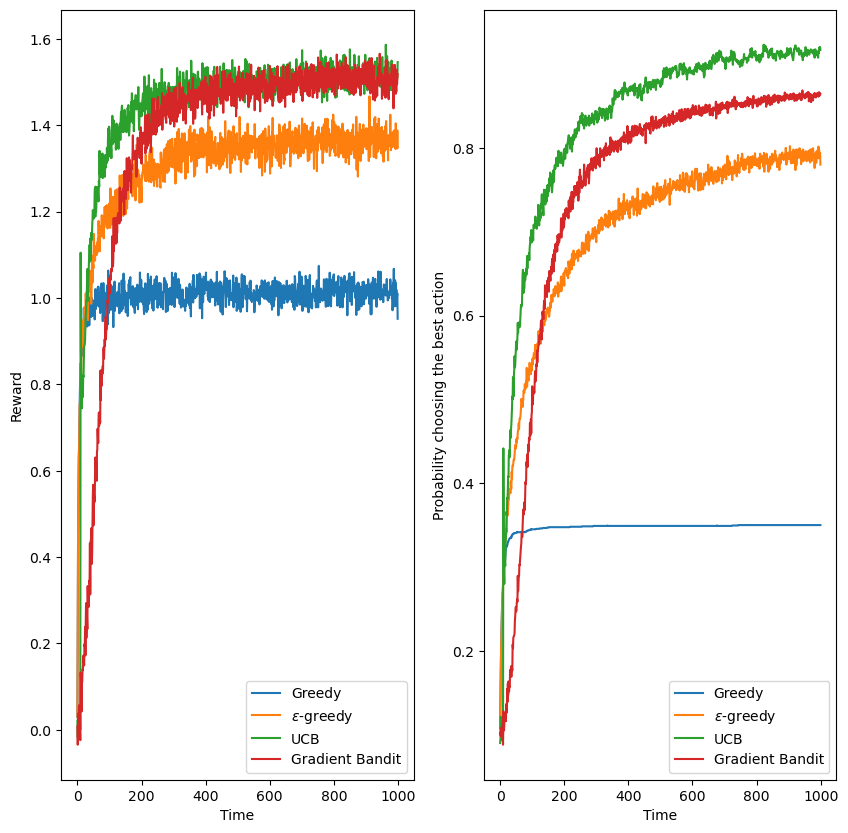

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.plot(greedy_reward)
ax2.plot(greedy_prob)
ax1.plot(eps_greedy_reward)
ax2.plot(eps_greedy_prob)
ax1.plot(UCB_reward)
ax2.plot(UCB_prob)
ax1.plot(gradient_bandit_reward)
ax2.plot(gradient_bandit_prob)
ax1.legend(['Greedy',r'$\varepsilon$-greedy','UCB','Gradient Bandit'])
ax2.legend(['Greedy',r'$\varepsilon$-greedy','UCB','Gradient Bandit'])
ax1.set_xlabel('Time')
ax2.set_xlabel('Time')
ax1.set_ylabel('Reward')
ax2.set_ylabel('Probability choosing the best action')

Clearly, gradient bandit and UCB outperforms $\varepsilon$-greedy strategy and greedy strategy has the worst performance. However, it seems hard to quantify how much better or worse a strategy is compared to another.


## Cumulative Regret Comparison

Recall from the analysis of UCB algorithm that cumulative regret is a good criterion measuring the performance of a strategy. It's been known that $\varepsilon$-greedy strategy has cumulative regret $O(T)$ and UCB has cumulative regret $\tilde{O}\left(\sqrt{T}\right)$ as $T\to\infty$. Why don't we check those conclusions numerically?

In the function below, we add $T$ as another argument since we hope to discover the change of cumulative regret w.r.t. $T$. It's mainly a copy of the "game" function above with slight modifications to keep track of the regret.

In [12]:
# Start the simulation of the game with a strategy specified 
# to generate actions
# Output: cumulative regret at each time step
def game_regret(strategy):
    # strategy can only take value as function names defined above
    if strategy not in ([greedy, eps_greedy, UCB, gradient_bandit]):
        error("Strategy value error!")
        
    # Record regret at each time step
    avg_regret_lst = np.zeros(MOD_T)
    
    for _ in range(MC_ITER):
        # Generate q_*(a)
        q_star_array = np.random.randn(MOD_K)
        
        # Figure out the best action
        best_action = np.argmax(q_star_array)
        
        # Maintain the estimation Q_t(a) and N_t(a)
        Q_est_array = np.zeros(MOD_K)
        N_est_array = np.zeros(MOD_K)
        
        # Maintain H_t(a) (only for gradient bandit)
        # and the mean of reward (incremental)
        H_est_array = np.zeros(MOD_K)
        mean_reward = 0
        
        for t in range(MOD_T):
            # Figure out the action with strategy
            action = strategy(t,Q_est_array,N_est_array,H_est_array)
            
            # Take the action, get the reward
            reward = get_reward(action,q_star_array)
            
            # Update the estimation
            Q_est_array[action] += (reward - Q_est_array[action]) / (N_est_array[action] + 1)
            N_est_array[action] += 1
            
            # Update H_t (only for gradient bandit)
            if strategy == gradient_bandit:
                aux_array = - softmax(H_est_array)
                aux_array[action] += 1 # I_{A_t = a} - \pi_t(a)
                mean_reward = (mean_reward * t + reward) / (t + 1)
                H_est_array += MOD_alpha * (reward - mean_reward) * aux_array
                
            # Record regrets
            avg_regret_lst[t] += ((q_star_array[best_action] - q_star_array[action]) / MC_ITER)
    
    # Cumulated sum of avg_regret_lst gives cumulated regret
    avg_cum_regret_lst = np.cumsum(avg_regret_lst)
    
    return avg_cum_regret_lst

In [13]:
# A larger MOD_T to see the asymptotic growth of cumulative regret
# A smaller MC_ITER to smooth the curve and save time
MOD_T = 10000
MC_ITER = 100

# Greedy
greedy_reg_lst = game_regret(greedy)

# Epsilon-greedy
MOD_EPS = 0.1
eps_greedy_reg_lst = game_regret(eps_greedy)

# UCB
MOD_delta = 0.05
UCB_reg_lst = game_regret(UCB)

# Gradient bandit
MOD_alpha = 0.1
gradient_bandit_reg_lst = game_regret(gradient_bandit)

Text(0, 0.5, 'Cumulative Regret')

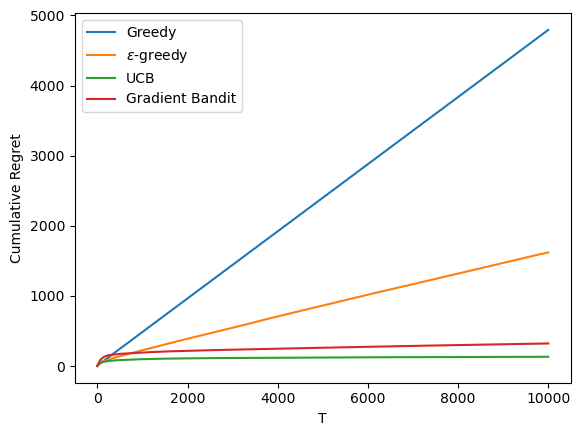

In [14]:
plt.plot(greedy_reg_lst)
plt.plot(eps_greedy_reg_lst)
plt.plot(UCB_reg_lst)
plt.plot(gradient_bandit_reg_lst)
plt.legend(['Greedy',r'$\varepsilon$-greedy','UCB','Gradient Bandit'])
plt.xlabel('T')
plt.ylabel('Cumulative Regret')

Text(0, 0.5, 'Log Cumulative Regret')

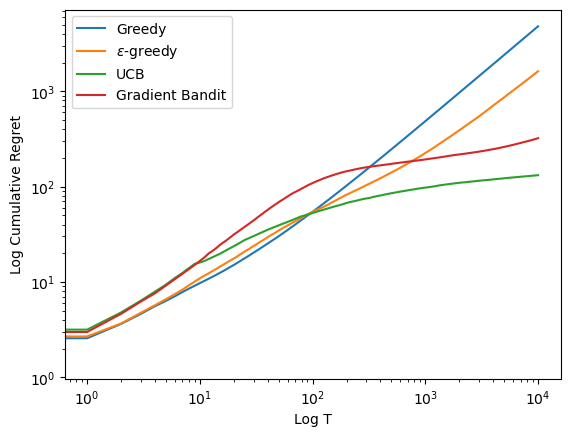

In [15]:
# Log-Log plot to distinguish asymptotic order
plt.loglog(greedy_reg_lst)
plt.loglog(eps_greedy_reg_lst)
plt.loglog(UCB_reg_lst)
plt.loglog(gradient_bandit_reg_lst)
plt.legend(['Greedy',r'$\varepsilon$-greedy','UCB','Gradient Bandit'])
plt.xlabel('Log T')
plt.ylabel('Log Cumulative Regret')

Clearly, gradient bandit and UCB both have cumulative regret increasing much slower asymptotically, around $\tilde{O}(\sqrt{T})$. Although $\varepsilon$-greedy strategy has much smaller absolute value of cumulative regret than the greedy strategy, it still grows at speed $O(T)$ asymptotically.